In [1]:
import numpy as np
from matplotlib import pyplot as plt

# DS Algorithms (DS 5440) Midterm Exam 

Welcome to your Midterm Exam.

## Exam Policies 

Please note the [Vanderbilt University Honor Code](https://studenthandbook.vanderbilt.edu/community-standards), of which you are subject to, before taking this exam:

*“Vanderbilt University students pursue all academic endeavors with integrity. They conduct themselves honorably, professionally and respectfully in all realms of their studies in order to promote and secure an atmosphere of dignity and trust. The keystone of our honor system is self-regulation, which requires cooperation and support from each member of the University community.”*

Basically, I want to see what you have *learned* in the class. Using ChatGPT to write all your answers will only hinder your understanding in the future. I am trusting that you only use your own notes, textbooks, and knowledge to complete this exam, and you are trusting me that I have given you all the resources you need to do this.

**Type your name below to acknowledge that you have read and agree to the above terms** 

## Question 1
**35 points**


Explain what ADAM did to improve upon gradient descent (what parameters did it add, what do those parameters mean, how does this change the behavior of gradient descent, etc.). Then, show a visualization (via code or something you drew) that demonstrates this improvement in comparison to gradient descent. 

## Answer 1

The Adam (Adaptive Moment Estimation) optimization algorithm combines elements of both Momentum and RMSprop.
1. Initialize parameters:
   - $ t = 0 $ (Time step)
   - $ m_0 = 0 $ (1st moment estimate, biased towards zero)
   - $ v_0 = 0 $ (2nd moment estimate, biased towards zero)
   - $ \eta $ (Learning rate)
   - $ \beta_1, \beta_2 $ (Exponential decay rates for moment estimates, typically close to 1)
   - $ \epsilon $ (A small constant to avoid division by zero, often $10^{-8}$)

2. For each iteration $t$:
   - Compute the gradient $g_t$ with respect to the loss function.
   - Update biased first moment estimate:
     $$
     m_t = \beta_1 \cdot m_{t-1} + (1-\beta_1) \cdot g_t
     $$
   - Update biased second moment estimate:
     $$
     v_t = \beta_2 \cdot v_{t-1} + (1-\beta_2) \cdot g_t^2
     $$
   - Correct bias in first moment:
     $$
     \hat{m}_t = \frac{m_t}{1 - \beta_1^t}
     $$
   - Correct bias in second moment:
     $$
     \hat{v}_t = \frac{v_t}{1 - \beta_2^t}
     $$
   - Update weights:
     $$
     w_{t+1} = w_t - \frac{\eta \cdot \hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
     $$

Adam combines the advantages of both Momentum (through $m_t$) and RMSprop (through $v_t$) to adaptively change the learning rates for each parameter.

Note that $\eta$, $\beta_1$, and $\beta_2$ are hyperparameters. Common choices are $\eta = 0.001$, $\beta_1 = 0.9$, and $\beta_2 = 0.999$.

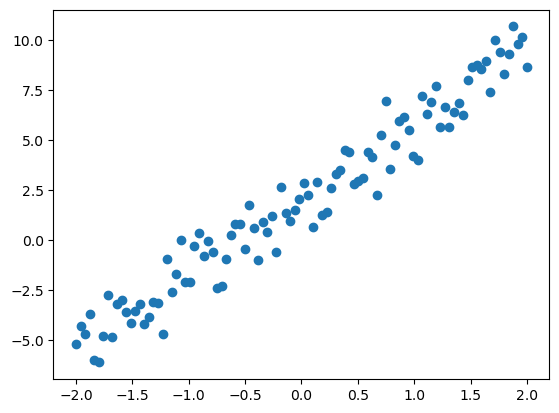

In [142]:
# define our true function
f = lambda x: 3.5*x + 2

# set up function to simulate data

# this function can simulate multidimensional data 
# default to 2 dimensions, 100 points
def simulation(f, dims = 2, N = 100):
    x = np.linspace(-2,2,N) # x values
    y = f(x) + np.random.randn(N) # adding our noise
    y = y[:,np.newaxis] # adding a dimension

    # initialize X as vector of 1s (x^0)
    X = x[:, np.newaxis]**0

    # loop to add each x
    for i in range(1, dims):
        X = np.hstack((X, x[:,np.newaxis]**i))

    return x,X,y

x, X, y = simulation(f)
plt.scatter(x,y)

In [154]:
def cost(X, y, w):
    return np.linalg.norm(X.dot(w)-y,axis=0)**2/X.shape[0]

def cost_grad(X,y,w):
    N = X.shape[0]
    return (2/N)*(X.T.dot(X).dot(w)-X.T.dot(y))


# define Adam
def mbgd_adam(dataset, labels, w_init=None, eta=1e-2, beta1 = 0.9, 
              beta2 = 0.999, epsilon = 1e-8, batch_size=10, epochs=1000, delta = 1e-4):
    if w_init is None:
        w_init = np.zeros((dataset.shape[1],1))

    # dataset dimensions
    num_data = dataset.shape[0] # number of data points
    dim_data = dataset.shape[1] # the shape of our X vector (how many weights are in our w_init) 

    # calculate number of batches in our dataset
    num_batches = int(num_data/batch_size)

    # reshape w_init to be a column vector
    w_init = np.asarray(w_init).reshape(dim_data,1)

    # initialize variables for stop criteria
    delta_w = 1

    # for plotting: save weights
    weights_list = []
    cost_list = []

    # do first update of weights
    w_old = w_init

    # init params
    z_old = 0
    v_old = 0
    t = 1

    # Start SGD Loop
    for epoch in range(epochs):
        # shuffle data (by shuffling indices)
        indices = np.random.permutation(num_data)
        shuffled_data = dataset[indices, :]
        shuffled_labels = labels[indices, :]

        # loop over all batches
        for batch_num in range(num_batches):
            # get current batch
            
            batch_start = batch_num * batch_size
            batch_end = (batch_num + 1) * batch_size
            batch = shuffled_data[batch_start:batch_end,:]
            batch_labels = shuffled_labels[batch_start:batch_end]

            # compute gradient
            grad = cost_grad(batch, batch_labels, w_old)
            

            # compute coefs: z_new, z_corr, v_new, v_corr
            z_new = beta1 *(z_old) + (1-beta1) * grad
            z_corr = z_new/(1 - beta1 **t)
            
            v_new = beta2*v_old + (1-beta2) * grad**2
            v_corr = v_new/(1 - beta2**t)

            #update weights
            w_new = w_old - eta * z_corr/(np.sqrt(v_corr) + epsilon)
            
            # save weights and costs for plotting
            weights_list.append(w_new)
            cost_list.append(cost(batch,batch_labels, w_new))

            # update stop criteria variables
            delta_w = np.linalg.norm(w_new - w_old)

            # previous values to current values
            w_old = w_new
            z_old = z_new
            v_old = v_new

        # check stop criteria at the end of the epoch
        
        if delta_w < delta:
            break

        t = t + 1

    # get rid of extra dimensions in weights/costs list for easy plotting
    weights_list = np.squeeze(np.asarray(weights_list))
    cost_list = np.squeeze(np.asarray(cost_list))

    print(f"Terminating MBGD Adam after {epoch} epochs with weight change of {delta_w}")

    return w_new, weights_list, cost_list
    


In [ ]:
# define minibatch gradient descent
def mbgd(dataset, labels, w_init=None, eta=1e-2, batch_size=10, epochs=1000, delta = 1e-4):
    if w_init is None:
        w_init = np.zeros((dataset.shape[1],1))

    # dataset dimensions
    num_data = dataset.shape[0] # number of data points
    dim_data = dataset.shape[1] # the shape of our X vector (how many weights are in our w_init) 

    # calculate number of batches in our dataset
    num_batches = int(num_data/batch_size)

    # reshape w_init to be a column vector
    w_init = np.asarray(w_init).reshape(dim_data,1)

    # initialize variables for stop criteria
    delta_w = 1

    # for plotting: save weights
    weights_list = []
    cost_list = []

    # do first update of weights
    w_old = w_init

    # Start SGD Loop
    for epoch in range(epochs):
        # shuffle data (by shuffling indices)
        indices = np.random.permutation(num_data)
        shuffled_data = dataset[indices, :]
        shuffled_labels = labels[indices, :]

        # loop over all batches
        for batch_num in range(num_batches):
            # get current batch
            
            batch_start = batch_num * batch_size
            batch_end = (batch_num + 1) * batch_size
            batch = shuffled_data[batch_start:batch_end,:]
            batch_labels = shuffled_labels[batch_start:batch_end]

            # compute gradient
            grad = cost_grad(batch, batch_labels, w_old)

            #update weights
            w_new = w_old - eta * grad
            
            # save weights and costs for plotting
            weights_list.append(w_new)
            cost_list.append(cost(batch,batch_labels, w_new))

            # update stop criteria variables
            delta_w = np.linalg.norm(w_new - w_old)

            # previous values to current values
            w_old = w_new

        # check stop criteria at the end of the epoch
        
        if delta_w < delta:
            break

    # get rid of extra dimensions in weights/costs list for easy plotting
    weights_list = np.squeeze(np.asarray(weights_list))
    cost_list = np.squeeze(np.asarray(cost_list))

    print(f"Terminating MBGD after {epoch} epochs with weight change of {delta_w}")

    return w_new, weights_list, cost_list
    


In [155]:
w_adam, wPath_adam, cPath_adam = mbgd_adam(X,y)

Terminating MBGD Adam after 196 epochs with weight change of 5.035296921978216e-05


In [ ]:
w_mbgd, wPath_mbdg, cPath_mbgd = mbgd(X,y)

Terminating MBGD after 999 epochs with weight change of 0.0024638477194682796


Text(0.5, 0, 'Iteration')

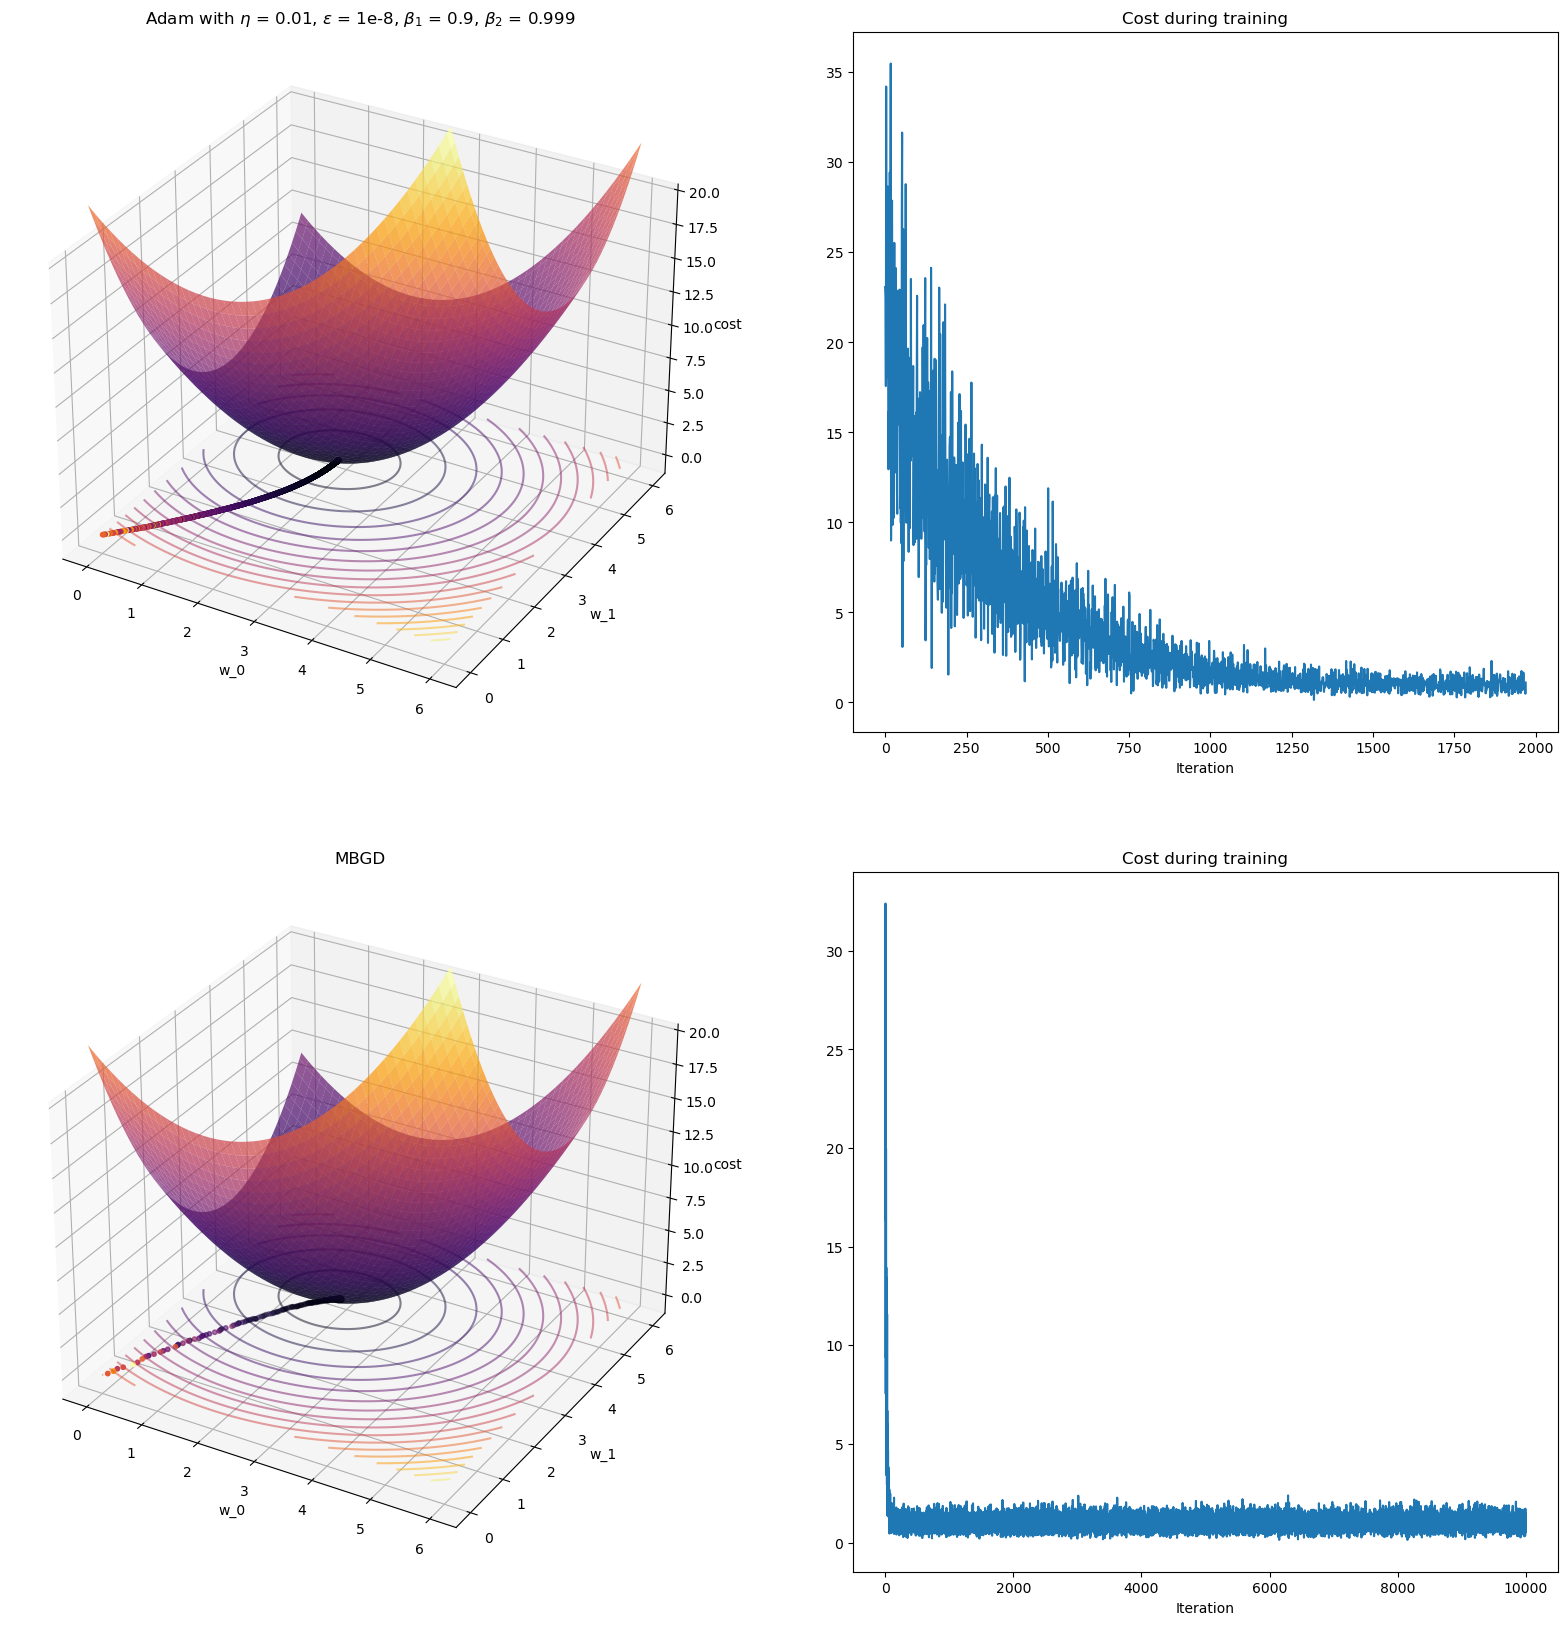

In [158]:
# plotting
len_w = 100
w_0 = np.linspace(0,6,len_w)
w_1 = np.linspace(0,6,len_w)
W_0, W_1 = np.meshgrid(w_0, w_1)

# combine and reshape mesh for calculation
wgrid = np.array([W_0,W_1]).reshape(2, len(w_0)**2)

# calculate on grid, and reshape back for plotting
costs = cost(X,y,wgrid).reshape(W_0.shape)


fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(221,projection='3d')
ax1.set_xlabel('w_0')
ax1.set_ylabel('w_1')
ax1.set_zlabel('cost')
ax1.set_zlim([-1,20])
ax1.scatter(wPath_adam[:,0],wPath_adam[:,1],s=10,c=cPath_adam,cmap='inferno')
ax1.plot_surface(W_0, W_1, costs,cmap='inferno',alpha=0.7)
ax1.contour(W_0, W_1, costs, zdir='z', offset=0, cmap='inferno',levels=20,alpha=0.5)
ax1.set_title("Adam with $\eta$ = 0.01, $\epsilon$ = 1e-8, $\\beta_1$ = 0.9, $\\beta_2$ = 0.999")


ax2 = fig.add_subplot(222)
ax2.plot(cPath_adam)
ax2.set_title("Cost during training")
ax2.set_xlabel("Iteration")



ax3 = fig.add_subplot(223,projection='3d')
ax3.set_xlabel('w_0')
ax3.set_ylabel('w_1')
ax3.set_zlabel('cost')
ax3.set_zlim([-1,20])
ax3.scatter(wPath_mbdg[:,0],wPath_mbdg[:,1],s=10,c=cPath_mbgd,cmap='inferno')
ax3.plot_surface(W_0, W_1, costs,cmap='inferno',alpha=0.7)
ax3.contour(W_0, W_1, costs, zdir='z', offset=0, cmap='inferno',levels=20,alpha=0.5)
ax3.set_title("MBGD")


ax4 = fig.add_subplot(224)
ax4.plot(cPath_mbgd)
ax4.set_title("Cost during training")
ax4.set_xlabel("Iteration")


### Advantage of Adam
Compare Mini Batch Gradient Descent Adam with original Mini Batch Gradient Descent, the advantage how Adam is obvious, as Mini Batch Gradient Descent Adam terminatd after 196 epochs with weight change of 5.035296921978216e-05, while original Mini Batch Gradient Descent terminated after 999 epochs (max epochs = 999) with weight change of 0.0024638477194682796.

## Question 2

**35 points**

### A)

What purpose does the activation function serve in a neural network? 

## Answer 2 (A)

1. **Non-linearity**  
   Without an activation function, even a deep network would behave like a single-layer perceptron. This is because summing the outputs of these layers would produce another linear function. By introducing non-linearity, the network can capture complex relationships in the data.

3. **Normalization**  
   Some activation functions, like sigmoid and tanh, constrain their outputs to a specific range. For instance:
   - Sigmoid outputs values in the range [0, 1]
   - Tanh outputs values between [-1, 1]  
   
   This constraint ensures neuron activations don't reach very high or very low values, promoting stability during learning.

4. **Sparse Activation**  
   Functions like the ReLU (Rectified Linear Activation) can result in sparse activations. That means for many input values, the output is zero. Sparse activations are considered to make the network more robust and simplify optimization.


### B)

Code an example network below demonstrating the difference between using a sigmoid activation function, and another activation function of your choosing (linear, ReLU, etc.). Your code only needs to show the forward pass of a network of your choice, and the differences between node activations when using the sigmoid function versus a different activation function.

### Answer 2 (B)

In [161]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

In [162]:
def simple_network_vectorized(combined_input, activation_function="sigmoid"):
    
    # Choose the activation function based on the parameter
    if activation_function == "sigmoid":
        act_func = sigmoid
    elif activation_function == "relu":
        act_func = relu
    else:
        raise ValueError("Invalid activation function. Choose either 'sigmoid' or 'relu'.")
    
    outputs = []
    num_data = combined_input.shape[0]

    # initialize weight matrices - notice the dimensions
    W_1 = np.random.randn(4,2)
    W_2 = np.random.randn(4,4)
    W_3 = np.random.randn(3,4)
    W_4 = np.random.randn(1,3)

    # initialize bias vectors
    b_1 = np.random.randn(4,1)
    b_2 = np.random.randn(4,1)
    b_3 = np.random.randn(3,1)
    b_4 = np.random.randn(1,1)
    
    # loop through training data
    for i in range(num_data):
        
        # get data point
        input = combined_input[i,:]
        
        # layer 1 - sigmoid of weights times input plus bias
        a_1 = act_func(W_1.dot(input.reshape(-1,1)) + b_1)
        # print(a_1, a_1.shape)

        # layer 2 - sigmoid of weights times a_1 plus bias
        a_2 = act_func(W_2.dot(a_1) + b_2)
        # print(a_2, a_2.shape)

        # layer 3 - sigmoid of weights times a_2 plus bias
        a_3 = act_func(W_3.dot(a_2) + b_3)
        # print(a_3, a_3.shape)

        # output layer
        output = act_func(W_4.dot(a_3) + b_4)
        # print(output, output.shape)
        
        # append to form output
        outputs.append(output)
    
    return np.squeeze(np.asarray(outputs)).reshape(-1,1)

In [163]:
# simulate data

def simple_dataset(N=1000):
    # Generate two features for each data point
    feature1 = np.linspace(-5, 5, N).reshape(N, 1)
    feature2 = np.random.uniform(-5, 5, N).reshape(N, 1)
    
    # Generate labels 
    labels = ((feature1 * feature2 > 0).astype(int)*2-1).reshape(N, 1)
    
    return feature1, feature2, labels

input1, input2, labels = simple_dataset()
combined_input = np.hstack((input1, input2))

In [166]:
simple_network_vectorized(combined_input, activation_function="sigmoid")[:10]

array([[0.02112177],
       [0.02455127],
       [0.0655863 ],
       [0.08823425],
       [0.05842211],
       [0.08587057],
       [0.02263137],
       [0.07363387],
       [0.07909173],
       [0.07379212]])

In [167]:
simple_network_vectorized(combined_input, activation_function="relu")[:10]

array([[ 1.20775389],
       [ 1.42978054],
       [ 8.75818806],
       [13.92014988],
       [ 7.49201725],
       [12.98295332],
       [ 1.20775389],
       [10.1852099 ],
       [11.282275  ],
       [10.17061011]])

## Question 3 

**30 points**

In previous classes, you explored the relationships between bias, variance, in-sample error, and out-of-sample error when fitting a model to data. In Chapter 2 of *Learning From Data*, there is a diagram of expected errors for a "small" model and a "complex" model (see below). Explain what this diagram means for machine learning by answering the following questions:

- What is E_out? What is E_in? How are they different? 

- How does model performance depend on the number of data points *N*? 

- What regions of this diagram represent bias and variance, respectively? You can describe this using words or a drawing. 

- How do bias, variance, and expected error compare with a small model vs a complex model?


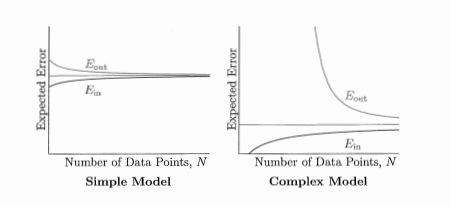


### Answer 3
 1. - $E_{in}$ is also called in-sample error, measuring the performance of the model on the training dataset. 
    - $E_{out}$ is also called out-of-sample error. $E_{out}$ is the generalized error, which means the expected error on all the datapoints, especially those are unseen data. 
    - The difference between them: The model training is to minimize $E_{in}$. And we only can have an estimate of $E_{out}$, but never get the exact $E_{out}$ unless we have all the data which is impossible.

 2. - The model performance on $E_{in}$ decreases when the number of data points N increases because for a specific model, when N goes up, it's harder for the model to fit all N data points. But the model performance on $E_{out}$ will increase as it has seen more data during training so that has a better performance on a generalized way.

 3. - Bias: The area between the Expected Error and x-axis, which means the permanent penalty for not having enough capacity to fit the true underlying function.
    - Variance: The area between the Expected Error and $E_{out}$

 4. - Small Model:
      - Bias: High
      - Variance: Low
      - Expected Error: High
    - Complex Model:
      - Bias: Low
      - Variance: High
      - Expected Error: Low 

## End of Exam

Congratulations - you have finished your exam! This hopefully gave you an idea of what you need to know for this course so far. For a 2-point bonus, please write down any questions you have about the class (something you'd like to review in class, concepts you don't understand, etc), or specific thoughts you have about the class given our unique experience this semester. I want to know how you're doing!

### Answer 4
Hope we can have more visualization or animation in the class. So it's easier to understand the concept like how difference between Adam and RMSprop.